# Case 2 -- Machine Learning for Finance 2025

<span style='color:crimson; font-weight: bold'>Submission deadline: Friday, 5 December 2025, 22:00 pm AMS. </span>

## Instructions
* This case covers the material discussed in wk2-wk5.
* Do not forget to create a group again, go to Canvas -> people -> groups -> Case2
* Each group submits _only one_ notebook via canvas on the assignment page. Only Jupyter notebooks are accepted via a group. 
* The notebook should be named `case2_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `case2_group03.ipynb`.
* Make sure you download the correct dataset. Loading the wrong set will lead to deduction of points. 
* The notebook should run without raising any errors.
* Deadline: **Friday 5 December 22:00 (AMS)**. Not meeting the deadline gives a discount of 10 pt per hour
* Standard plagiarism and AI checks are in place
* As a standard anti-fraud measure, I can at random select a number of you to explain your code 
and answers. Any one of you must be able to explain any part of the code. Failure to explain 
your answers will result in a deduction of credits for this case for the whole group. Each group is responsible for all group members being able to explain any part the code
* If you need to make a Table or Figure, do this in JF-style. (hence provide a sufficient caption explaining (NOT interpreting) what is in the Figure/Table)
* If you test something, provide H0/HA, the test statistic (formula and number) and your conclusion.
* Do not spend time on optimizing the speed of your code. However, if it runs for more than 5 minutes, we will terminate 
it.

----

<div style="font-size:24px; text-align:center; font-weight:bold">Good luck!</div>

----


# Case 2 - Modeling defaults

In this case you will model the defaults of U.K. companies by using several classification models. 
The goal is to see whether sophisticated machine learning models such as decision trees, neural networks and ensemble learning methods can beat a simple logit model. 

Download your own dataset from Canvas. You have the following variables at your disposal:
* **org_id**: organisation ID
* **sic2**: 2-Digit SIC (Standard Industrial Classification) Codes
* **year**: time in year
* **def**: binary indicator: 1 if the company defaulted, 0 else
* **wkta**: working capital over total assets
* **reta**: retained earnings over total assets
* **ebitta**: earnings before interest and taxes over total assets 
* **mv**: the market to book value
  
First take a look at the data, then test different algorithms, make predictions and provide an answer to the main questios of the case

State your imports below.

In [63]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, fbeta_score, confusion_matrix, 
                             classification_report)
from sklearn.preprocessing import StandardScaler

# Neural Network libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset from Excel
df = pd.read_excel('data_MLF_case2_group_26.xlsx', sheet_name='Data')


# Part I: Preprocessing (15 points)

Import your data from excel. Then perform the following tasks:
1. Check for missing values and delete these.
2. Do the features contain any outliers? If so, treat them carefully with an explanation.
3. Show the correlations between the (labels and the) features. Comment on the sign of 2 randomly selected features
4. Show summary statistics in **Table 1**

In [64]:
### 1

print(df.head())
print(df.shape)

print("")
print("1. Dealing with missing values")
print("")
# Check for missing values
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Delete rows with missing values
df = df.dropna()

print(f"\nOriginal dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df)}")
print(f"Rows removed: {len(df) - len(df)}")

   org_id  sic2  year  def      wkta      reta    ebitta        mv
0    3671    33  2001    0  0.153244  0.113063  0.070824  1.806667
1    3174    59  2001    0  0.380485  0.203497  0.126315  1.734991
2    3289    78  1988    0  0.039873  0.000000  0.031834  0.196416
3    7872    48  2001    0  0.202144 -0.160948  0.062240 -0.238152
4    1275    49  1991    0 -0.510000 -0.260833  0.025862 -0.130025
(1025, 8)

1. Dealing with missing values

org_id     0
sic2       0
year       0
def        0
wkta      42
reta      42
ebitta    42
mv        42
dtype: int64

Total missing values: 168

Original dataset size: 983
Cleaned dataset size: 983
Rows removed: 0


1. 42 rows were found with missing values and subsequently deleted.

In [65]:
### 2

print("")
print("2. Looking at outliers")
print("")
print(df.describe())

# Define features for outlier detection
features = ['wkta', 'reta', 'ebitta', 'mv']

# Calculate outliers using IQR method
print("\nOutlier Detection using IQR Method:")
print("="*60)
for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\n{feature}:")
    print(f"  Lower bound: {lower_bound:.4f}")
    print(f"  Upper bound: {upper_bound:.4f}")
    print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")



2. Looking at outliers

            org_id        sic2         year         def        wkta  \
count   983.000000  983.000000   983.000000  983.000000  983.000000   
mean   3514.200407   42.203459  1995.636826    0.107833    0.134980   
std    2653.021723   18.547547     6.745093    0.310327    0.231457   
min       4.000000    1.000000  1981.000000    0.000000   -0.510000   
25%    1213.000000   29.000000  1989.000000    0.000000    0.009800   
50%    2825.000000   38.000000  1999.000000    0.000000    0.112705   
75%    5784.000000   50.000000  2001.000000    0.000000    0.273275   
max    9147.000000   99.000000  2002.000000    1.000000    0.730000   

             reta      ebitta          mv  
count  983.000000  983.000000  983.000000  
mean     0.091985    0.066591    0.604055  
std      0.390075    0.106839    1.558802  
min     -1.220000   -0.330000   -3.780000  
25%     -0.050325    0.026088   -0.029801  
50%      0.115826    0.079463    0.845793  
75%      0.270008    0.1194

2. While there are values outside 1.5 std. dev. out of the IQR ranges, they don't appear to be data misinuputs or observations outside the realm of possibility. As we look at default probability, keeping these extreme distributions makes sense, as a lot of the risk is held in these wide tails. 

In [66]:
### 3

3. Correlations

# Part II: Training (50 points)

We've familiarized ourselves with the data, so now we're going to train some models to model the probability of default. 
Use *wkta, reta, ebitta* and *mv* as features in the following models:
- Model 1: The logistic classifier 
- Model 2: The decision tree
- Model 3: A neural network
- Model 4: Gradient Boosting for Classicifation

Split the data into a random training, validation and test using using the 60/20/20 rule. Pin down your random sets by providing the seed.
If there are hyperparameters, tune these in the correct way and show plots - using an appropriate measure - to explain your final hyperparameter(s). Explain why you have used this measure!

Create **Table 2** by showing the accuracy, recall, precision, F1 score, and the $F_\beta$ using the test set for each model.
Choose your own $\beta$ with explanation. Interpret the outcomes. Did you expect these results? Why/Why NOT?

### More information about Model 2
Estimate a dicision tree using the default hyperparameteres of Python. Just tune the *maximum depth* parameter. 

### More information about Model 3
Set the following conditions fixed: 
- **Activation function**: *Relu* for hidden layers
- **dropout ratio**: put this after each hidden layer and set it equal to 0.2
- **epochs**: 50
- **batch size**: 10

When compiling the model, set the following conditions fixed:
- Use loss = 'categorical_crossentropy'
- optimizer='adam'
- metrics=accuracy

Now tune the following hyperparameters: 
- the number of **hidden** layers: 1 or 2.
- Number of nodes per hidden layer: 16 or 8. 

### More information about Model 4
Set the following hyperparameters fixed:
- Learning rate: 0.8
- random state: 0
- max depth: 2

Tune the the parameter *n_estimators*.



In [67]:
# Model training


# Data preparation 
X = df[['wkta', 'reta', 'ebitta', 'mv']]
y = df['def']

# Splitting the data into training (60%), validation (20%), and testing (20%) sets randomly
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 x 0.8 = 0.2

# Scale the features 
# tree models don’t need scaling, but NN and logistic do
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [68]:
# Model 1: Logistic Regression

log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)


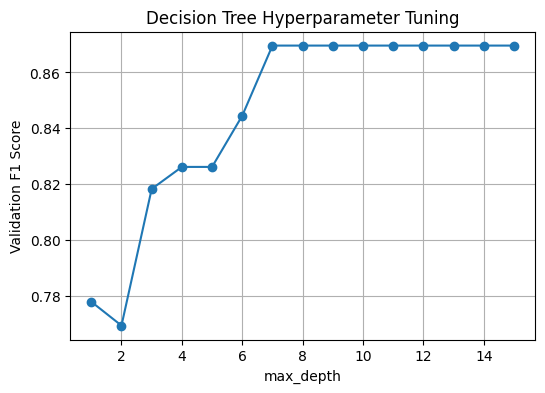

In [69]:
# Model 2: Decision Tree
# Hyperparameter tuning for max_depth

# Depth values: 1 to 15
depths = range(1, 16)
val_scores = []

# Tune max_depth on validation set
for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=0)
    tree.fit(X_train, y_train)
    preds = tree.predict(X_val)
    val_scores.append(f1_score(y_val, preds))

# Plot tuning curve
plt.figure(figsize=(6,4))
plt.plot(depths, val_scores, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Validation F1 Score")
plt.title("Decision Tree Hyperparameter Tuning")
plt.grid(True)
plt.show()

# Select best depth
best_depth = depths[np.argmax(val_scores)]
dt = DecisionTreeClassifier(max_depth=best_depth, random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [70]:
# Model 3: Neural Network
# Hyperparameter tuning for number of layers and neurons per layer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# --- prepare labels for categorical crossentropy ---
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat   = to_categorical(y_val, num_classes=2)
y_test_cat  = to_categorical(y_test, num_classes=2)

def build_model(n_layers, n_nodes):
    # Clear previous graph just in case (helps prevent weird crashes in notebooks)
    K.clear_session()

    model = Sequential()
    # Explicit Input layer (no warning now)
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dropout(0.2))

    if n_layers == 2:
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# --- hyperparameter search ---
configs = [(1, 16), (1, 8), (2, 16), (2, 8)]
val_acc_results = {}
histories = {}

for layers, nodes in configs:
    print(f"Training NN config: layers={layers}, nodes={nodes}")
    model = build_model(layers, nodes)
    history = model.fit(
        X_train_scaled, y_train_cat,
        validation_data=(X_val_scaled, y_val_cat),
        epochs=50,
        batch_size=10,
        verbose=0
    )
    val_acc = max(history.history['val_accuracy'])
    val_acc_results[(layers, nodes)] = val_acc
    histories[(layers, nodes)] = history

best_config = max(val_acc_results, key=val_acc_results.get)
print("Best NN config:", best_config)

# --- retrain best model on train+val (optional but nice) ---
X_train_full_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_train_full_cat    = to_categorical(
    np.concatenate([y_train.values, y_val.values]),
    num_classes=2
)

best_nn = build_model(*best_config)
best_nn.fit(
    X_train_full_scaled, y_train_full_cat,
    epochs=50,
    batch_size=10,
    verbose=0
)

nn_pred_prob = best_nn.predict(X_test_scaled)
y_pred_nn = np.argmax(nn_pred_prob, axis=1)


Training NN config: layers=1, nodes=16
Training NN config: layers=1, nodes=8
Training NN config: layers=2, nodes=16
Training NN config: layers=2, nodes=8
Best NN config: (2, 8)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


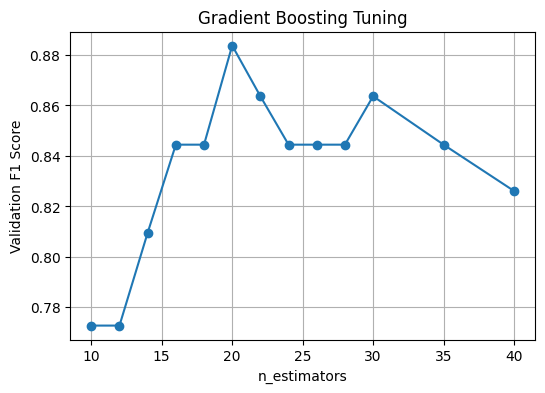

In [71]:
# Model 4: Gradient Boosting
# Hyperparameter tuning for n_estimators

estimators = [10,12,14,16,18,20,22,24,26,28,30,35,40]
val_scores_gb = []

# Tune n_estimators on validation set
for n in estimators:
    gb = GradientBoostingClassifier(
        n_estimators=n,
        learning_rate=0.8,
        max_depth=2,
        random_state=0
    )
    gb.fit(X_train, y_train)
    preds = gb.predict(X_val)
    val_scores_gb.append(f1_score(y_val, preds))

# Plot tuning curve
plt.figure(figsize=(6,4))
plt.plot(estimators, val_scores_gb, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("Validation F1 Score")
plt.title("Gradient Boosting Tuning")
plt.grid(True)
plt.show()

# Fit best model with optimal n_estimators and predefined hyperparameters (learning_rate=0.8, max_depth=2)
best_n = estimators[np.argmax(val_scores_gb)]
gb = GradientBoostingClassifier(
    n_estimators=best_n,
    learning_rate=0.8,
    max_depth=2,
    random_state=0
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)



In [72]:
# Metrics Table

models = {
    "Logistic": y_pred_log,
    "Decision Tree": y_pred_dt,
    "Neural Network": y_pred_nn,
    "Gradient Boosting": y_pred_gb
}

results = []

for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    fb = fbeta_score(y_test, preds, beta=2)

    results.append([name, acc, prec, rec, f1, fb])

df_results = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1", "Fβ (β=2)"
])

print(df_results)





               Model  Accuracy  Precision    Recall        F1  Fβ (β=2)
0           Logistic  0.974619   0.863636  0.904762  0.883721  0.896226
1      Decision Tree  0.969543   0.857143  0.857143  0.857143  0.857143
2     Neural Network  0.969543   0.826087  0.904762  0.863636  0.887850
3  Gradient Boosting  0.954315   0.772727  0.809524  0.790698  0.801887


# Part III: Estimating a tree using only two features (30 points)

Select only **wkta** and **reta** as features. Then estimate again a decision tree, again tuning the *maximum depth* hyperparameter.
Lets call this model **Decision Tree Small**

Answer the following questions:
- Is the hyperparameter of your decision tree of Part II robust?
- Does Decision Tree Small outperform the best model of Part II?
- Does Decision Tree Small beat the logit *with the same two features*?

Also make a plot of your final decision tree with the two features as done in the tutorial/lecture. Interpret this figure. 

Put your test results in **Table 3**. Interpret your results and relate these to main question of the case.


# Discussion (5 points)

Provide a short discussion about the way we tune the hyperparameters. Pay attention to the charactaristics of the data at hand while answering this question.